# Pytorch Geometric

In [1]:
# Run only once; make sure torch is installed
#!pip install torch_geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cpu.html

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

In [3]:
from torch_geometric.data import Data
import torch
import numpy as np

def generate_sample_graph(n_nodes=64, dn=8, k=3):
    x_vals = torch.linspace(0, 2 * np.pi, n_nodes)
    phase = np.random.uniform(0, 2*np.pi)
    y_true = torch.sin(2*x_vals + phase)

    y_obs = torch.full_like(y_true, float('nan'))
    idx = torch.arange(0, n_nodes, dn)
    y_obs[idx] = y_true[idx]

    is_observed = ~torch.isnan(y_obs)
    input_feat = torch.stack([
        torch.nan_to_num(y_obs, nan=0.0),
        is_observed.float()
    ], dim=1)

    # k-neighbor graph
    edges = []
    for i in range(n_nodes):
        for j in range(1, k + 1):
            if i - j >= 0:
                edges.append((i, i - j))
            if i + j < n_nodes:
                edges.append((i, i + j))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(
        x=x_vals.unsqueeze(1),
        y=y_true.unsqueeze(1),
        y_obs=y_obs.unsqueeze(1),
        x_feat=input_feat,
        edge_index=edge_index
    )

In [4]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNInterpolator(torch.nn.Module):
    def __init__(self, hidden1=64, hidden2=128):
        super().__init__()
        self.gcn1 = GCNConv(2, hidden1)
        self.gcn2 = GCNConv(hidden1, hidden2)
        self.out  = GCNConv(hidden2, 1)

    def forward(self, data):
        x = data.x_feat
        x = F.relu(self.gcn1(x, data.edge_index))
        x = F.relu(self.gcn2(x, data.edge_index))
        return self.out(x, data.edge_index)

In [5]:
from torch_geometric.loader import DataLoader

# Dataset
dataset = [generate_sample_graph() for _ in range(200)]
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Model and optimizer
model = GCNInterpolator()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in loader:
        pred = model(batch)
        mask = ~torch.isnan(batch.y_obs)
        loss = F.mse_loss(pred[~mask], batch.y[~mask])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}  Loss: {total_loss:.4f}")

Epoch   0  Loss: 3.0135
Epoch  10  Loss: 0.5905
Epoch  20  Loss: 0.5488
Epoch  30  Loss: 0.5223
Epoch  40  Loss: 0.5554
Epoch  50  Loss: 0.5038
Epoch  60  Loss: 0.5452
Epoch  70  Loss: 0.5005
Epoch  80  Loss: 0.5129
Epoch  90  Loss: 0.5107


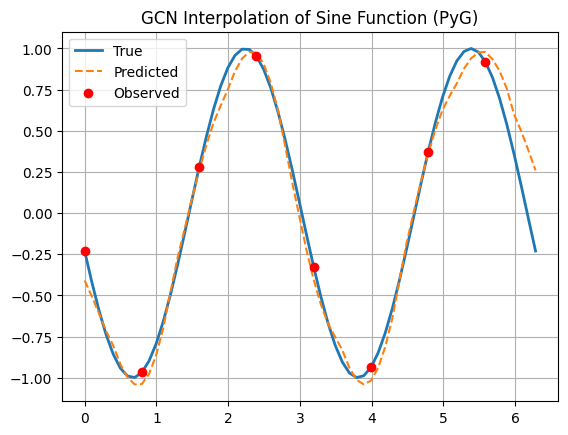

In [6]:
import matplotlib.pyplot as plt

test_data = generate_sample_graph()
test_data.batch = torch.zeros(test_data.num_nodes, dtype=torch.long)

model.eval()
with torch.no_grad():
    pred = model(test_data).squeeze().cpu()
    true = test_data.y.squeeze()
    obs = test_data.y_obs.squeeze()
    x = test_data.x.squeeze()

plt.plot(x, true, label="True", linewidth=2)
plt.plot(x, pred, label="Predicted", linestyle='--')
plt.scatter(x[~torch.isnan(obs)], obs[~torch.isnan(obs)], color="red", label="Observed", zorder=5)
plt.legend()
plt.title("GCN Interpolation of Sine Function (PyG)")
plt.grid(True)
plt.savefig("geometric_demo.png")
plt.show()